**Importing Packages**

In [36]:

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import pickle
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Data Cleaning**

In [37]:

stop=set(stopwords.words("english"))

In [38]:

def clean(text):
    text=text.lower()
    obj=re.compile(r"<.*?>")                     #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
    stemmer = SnowballStemmer("english")
    text=[stemmer.stem(word) for word in text.split() if word not in stop]
    
    return " ".join(text)

In [39]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [40]:

df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [41]:
# Drop unnecessary columns
df = df.drop(['job_id', 'location', 'department', 'benefits','function','salary_range'], axis=1)

#remove rows with 5 or more nan values
df = df.dropna(thresh=len(df.columns)-5)

print(df.shape)

(17605, 12)


In [42]:
df = df.fillna('')

df.head()

,title,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,,,,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,0


In [43]:
text_features=['title','company_profile','description','requirements']
for i in text_features:
  df[i]=df[i].apply(clean)

**Data Visualization**

In [44]:
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [45]:
df.fraudulent.value_counts()

0    16791
1      814
Name: fraudulent, dtype: int64

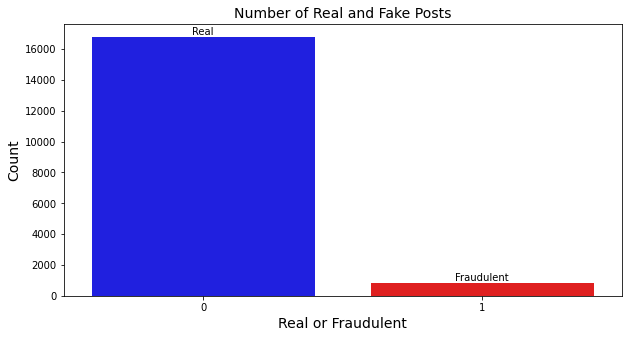

In [46]:
labels = ['Real', 'Fraudulent']
plt.figure(figsize = (10,5))
ax = sb.countplot(x="fraudulent", data = df, palette = ["blue", "red"])
ax.bar_label(ax.containers[0], fmt='%g', label_type = 'edge', labels = labels)
plt.title("Number of Real and Fake Posts", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14});
plt.xlabel('Real or Fraudulent', fontdict = {"fontsize" : 14})
plt.show()

In [47]:
#@title
#Label counts for each attribute
labelcountlist = []
for x in df.columns:
        labelcountlist.append((len(df[x].unique())))
labelcount = pd.DataFrame({'Attribute': df.columns, 'Count': labelcountlist})
print(labelcount)

              Attribute  Count
0                 title  10047
1       company_profile   1707
2           description  14166
3          requirements  11687
4         telecommuting      2
5      has_company_logo      2
6         has_questions      2
7       employment_type      6
8   required_experience      8
9    required_education     14
10             industry    132
11           fraudulent      2


In [48]:
#@title
#analysing each column data
df.title.value_counts()

english teacher abroad                                  406
custom servic associ                                    199
graduat english teacher abroad convers                  144
custom servic associ part time                           97
softwar engin                                            94
                                                       ... 
bi practic manag                                          1
west coast region channel manag rcm                       1
peoplesoft hrms consult                                   1
busi develop manag japan                                  1
project cost control staff engin cost control exp tx      1
Name: title, Length: 10047, dtype: int64

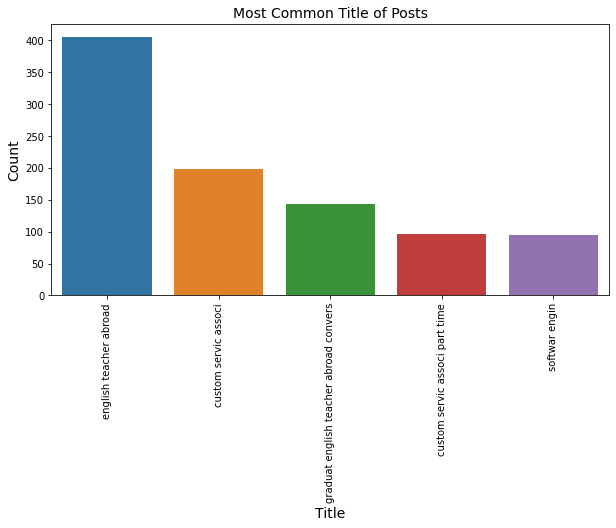

In [49]:
#@title
title = df.title.value_counts()[:5]

plt.figure(figsize = (10,5))
sb.barplot(x = title.index, y = title )
plt.title("Most Common Title of Posts", fontdict = {"fontsize" : 14})
plt.xlabel("Title", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=90);

In [50]:
#@title
employment_type=df.employment_type.value_counts().drop('')
employment_type

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

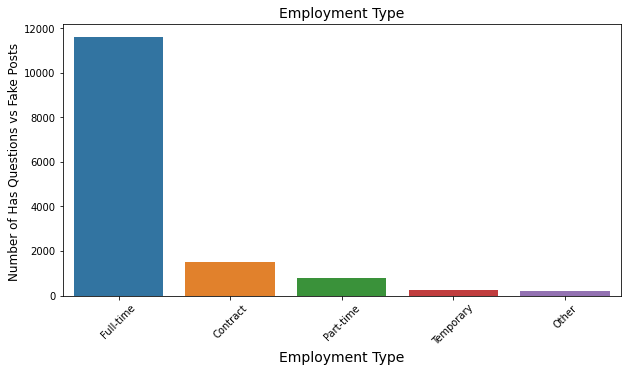

In [51]:
#@title
plt.figure(figsize = (10,5))
sb.barplot(x = employment_type.index, y = employment_type)
plt.title("Employment Type", fontdict = {"fontsize" : 14})
plt.xlabel("Employment Type", fontdict = {"fontsize" : 14})
plt.ylabel("Number of Has Questions vs Fake Posts ", fontdict = {"fontsize" : 12})
plt.xticks(rotation = 45);

In [52]:
#@title
required_experience=df.required_experience.value_counts().drop('')
required_experience

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

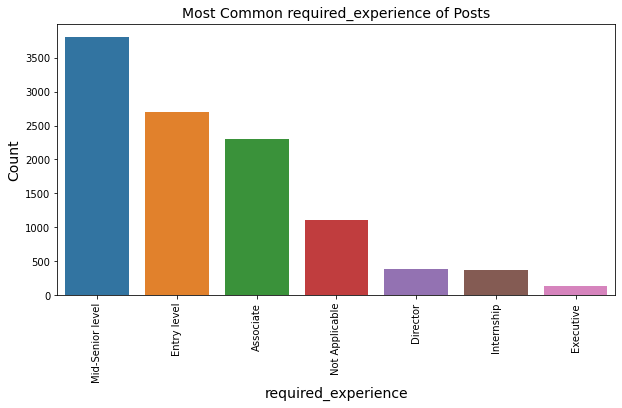

In [53]:
#@title
plt.figure(figsize = (10,5))
sb.barplot(x = required_experience.index, y = required_experience )
plt.title("Most Common required_experience of Posts", fontdict = {"fontsize" : 14})
plt.xlabel("required_experience", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=90);

In [54]:
#@title
required_education=df.required_education.value_counts().drop('')
required_education

Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

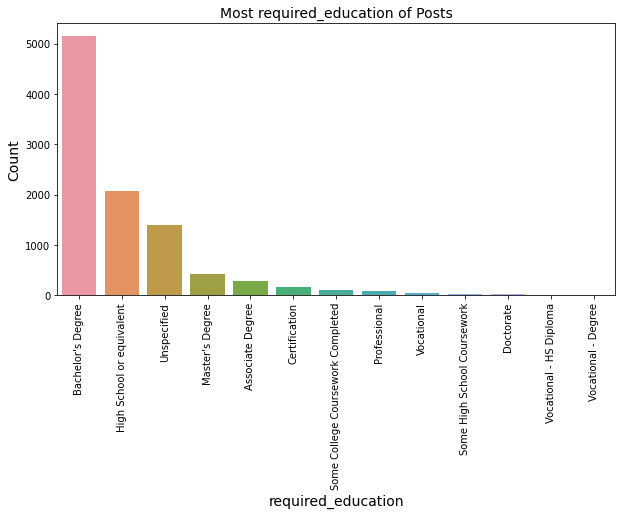

In [55]:
#@title
plt.figure(figsize = (10,5))
sb.barplot(x = required_education.index, y = required_education )
plt.title("Most required_education of Posts", fontdict = {"fontsize" : 14})
plt.xlabel("required_education", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=90);

In [56]:
#@title
df.industry.value_counts().drop('')

Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
                                       ... 
Shipbuilding                              1
Sporting Goods                            1
Museums and Institutions                  1
Wine and Spirits                          1
Ranching                                  1
Name: industry, Length: 131, dtype: int64

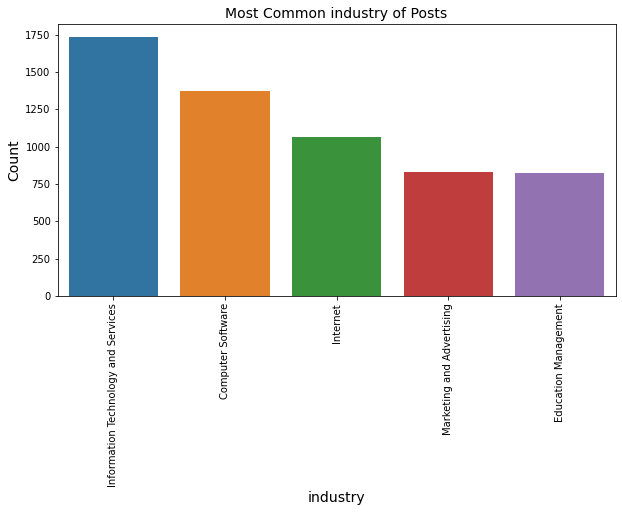

In [57]:
#@title
industry=df.industry.value_counts().drop('')[:5]
plt.figure(figsize = (10,5))
sb.barplot(x = industry.index, y = industry )
plt.title("Most Common industry of Posts", fontdict = {"fontsize" : 14})
plt.xlabel("industry", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=90);

In [58]:
#@title
df.has_company_logo.value_counts()

1    14180
0     3425
Name: has_company_logo, dtype: int64

In [59]:
#@title
has_company_logo1 = df.has_company_logo[df.fraudulent == 1]
has_company_logo1 = has_company_logo1.value_counts()
has_company_logo1

0    531
1    283
Name: has_company_logo, dtype: int64

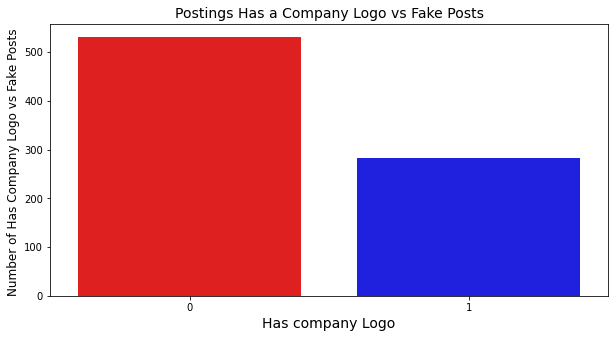

In [60]:
#@title
palette = ["red", "blue" ]
plt.figure(figsize = (10,5))
sb.barplot(x = has_company_logo1.index, y = has_company_logo1, palette = palette)
plt.title("Postings Has a Company Logo vs Fake Posts", fontdict = {"fontsize" : 14})
plt.xlabel("Has company Logo", fontdict = {"fontsize" : 14})
plt.ylabel("Number of Has Company Logo vs Fake Posts ", fontdict = {"fontsize" : 12})
plt.xticks(rotation=0);

In [61]:
#@title
df.has_questions.value_counts()

0    8869
1    8736
Name: has_questions, dtype: int64

In [62]:
#@title
has_questions1 = df.has_questions[df.fraudulent == 1].value_counts()
has_questions1

0    568
1    246
Name: has_questions, dtype: int64

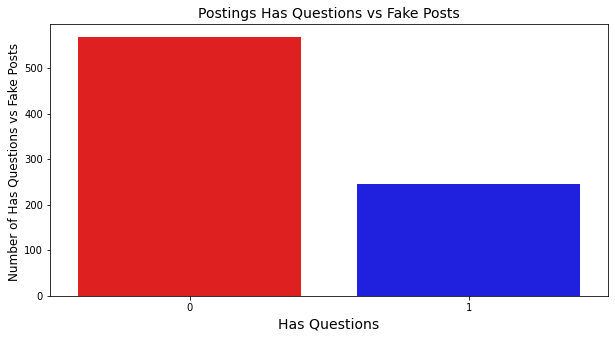

In [63]:
#@title
plt.figure(figsize = (10,5))
sb.barplot(x = has_questions1.index, y = has_questions1, palette = palette)
plt.title("Postings Has Questions vs Fake Posts", fontdict = {"fontsize" : 14})
plt.xlabel("Has Questions", fontdict = {"fontsize" : 14})
plt.ylabel("Number of Has Questions vs Fake Posts ", fontdict = {"fontsize" : 12})
plt.xticks(rotation=0);

In [64]:
#@title
df.telecommuting.value_counts()

0    16844
1      761
Name: telecommuting, dtype: int64

In [65]:
#@title
telecommuting1 = df.telecommuting[df.fraudulent == 1].value_counts()
telecommuting1

0    751
1     63
Name: telecommuting, dtype: int64

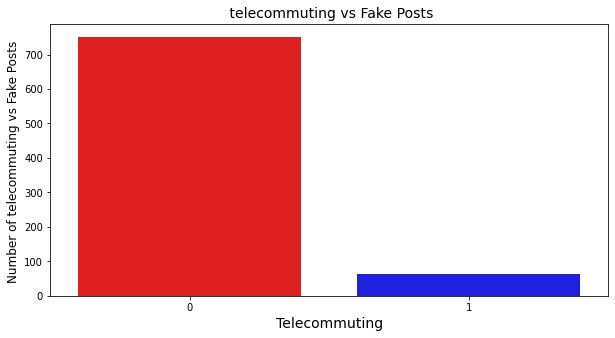

In [66]:
#@title
plt.figure(figsize = (10,5))
sb.barplot(x = telecommuting1.index, y = telecommuting1, palette = palette)
plt.title(" telecommuting vs Fake Posts", fontdict = {"fontsize" : 14})
plt.xlabel("Telecommuting", fontdict = {"fontsize" : 14})
plt.ylabel("Number of telecommuting vs Fake Posts ", fontdict = {"fontsize" : 12})
plt.xticks(rotation=0);

In [67]:
#@title
df.fillna('')
df.to_csv('final_dataset.csv', index=False)

In [68]:
#@title
df.head()

,title,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent
0,market intern,food creat groundbreak award win cook site sup...,food fast grow jame beard award win onlin food...,experi content manag system major plus blog co...,0,1,0,Other,Internship,,,0
1,custom servic cloud video product,second world cloud video product servic second...,organis focus vibrant awesom passion custom se...,expect key respons communic client second team...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,0
2,commiss machineri assist cma,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement pre commiss commiss procedur rotari ...,0,1,0,,,,,0
3,account execut washington dc,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educ bachelor master gis busi administr relat ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,0
4,bill review manag,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualif rn licens state texasdiploma bachelor s...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,0


In [69]:
#@title
preprocessor = ColumnTransformer(
    transformers=[
        ('text1', TfidfVectorizer(stop_words='english'),'title'),
        ('text2', TfidfVectorizer(stop_words='english'),'company_profile'),
        ('text3', TfidfVectorizer(stop_words='english'),'description'),
        ('text4', TfidfVectorizer(stop_words='english'),'requirements'),
        ('category5', OneHotEncoder(), ['telecommuting']),
        ('category6', OneHotEncoder(), ['has_company_logo']),
        ('category7', OneHotEncoder(), ['has_questions']),
        ('category8', OneHotEncoder(), ['employment_type']),
        ('category9', OneHotEncoder(), ['required_experience']),
        ('category10', OneHotEncoder(), ['required_education']),
        ('category11', OneHotEncoder(handle_unknown='ignore'), ['industry'])
    ])

In [70]:
#@title
X_train, X_test, y_train, y_test = train_test_split(df[['title','company_profile','description','requirements','telecommuting','has_company_logo','has_questions','employment_type','required_experience','required_education','industry']], df['fraudulent'], test_size=0.2, random_state=42)

# Fit and transform the training data into feature vectors
X_train = preprocessor.fit_transform(X_train)

# Transform the testing data into feature vectors
X_test = preprocessor.transform(X_test)


**Modeling**

In [71]:
#@title
Model_Score1= []
Model_Score2=[]
Model_Score3=[]
Model_Score4=[]
Model_Score5=[]
Model_Name = []

In [72]:
#@title
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score,classification_report
import seaborn as sns

**Logistic Regression**

In [73]:
#@title
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

In [74]:
#@title
roc_auc_score(y_test, log_reg_pred)
print (classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3359
           1       0.95      0.63      0.76       162

    accuracy                           0.98      3521
   macro avg       0.97      0.81      0.87      3521
weighted avg       0.98      0.98      0.98      3521



<Axes: >

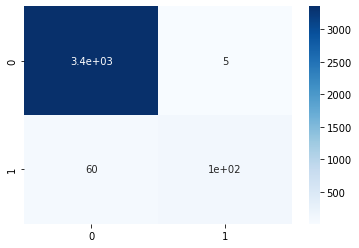

In [75]:
#@title
Model_Name.append('Logistic_Regression')
Model_Score1.append(round(accuracy_score(y_test, log_reg_pred), 4))
Model_Score2.append(round(precision_score(y_test, log_reg_pred), 4))
Model_Score3.append(round(recall_score(y_test, log_reg_pred), 4))
Model_Score4.append(round(f1_score(y_test, log_reg_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, log_reg_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, log_reg_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

**SVC**

In [76]:
#@title
svc = SVC()
svc.fit(X_train, y_train)
svc_pred=svc.predict(X_test)

In [77]:
#@title
print (roc_auc_score(y_test, svc_pred))
print (classification_report(y_test, svc_pred))

0.7898257491390368
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3359
           1       0.98      0.58      0.73       162

    accuracy                           0.98      3521
   macro avg       0.98      0.79      0.86      3521
weighted avg       0.98      0.98      0.98      3521



<Axes: >

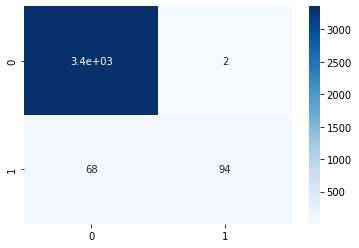

In [78]:
#@title
Model_Name.append('SVC')
Model_Score1.append(round(accuracy_score(y_test, svc_pred), 4))
Model_Score2.append(round(precision_score(y_test, svc_pred), 4))
Model_Score3.append(round(recall_score(y_test, svc_pred), 4))
Model_Score4.append(round(f1_score(y_test, svc_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, svc_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, svc_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

**Decision Tree**

In [79]:
#@title
dt=DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred=dt.predict(X_test)

In [80]:
#@title
print (roc_auc_score(y_test, dt_pred))
print (classification_report(y_test, dt_pred))

0.8955781225305885
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3359
           1       0.77      0.80      0.79       162

    accuracy                           0.98      3521
   macro avg       0.88      0.90      0.89      3521
weighted avg       0.98      0.98      0.98      3521



<Axes: >

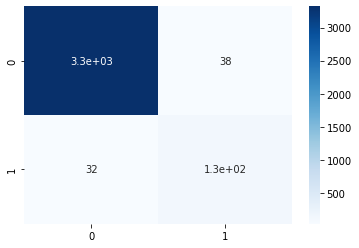

In [81]:
#@title
Model_Name.append('Decision_Tree')
Model_Score1.append(round(accuracy_score(y_test, dt_pred), 4))
Model_Score2.append(round(precision_score(y_test, dt_pred), 4))
Model_Score3.append(round(recall_score(y_test, dt_pred), 4))
Model_Score4.append(round(f1_score(y_test, dt_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, dt_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, dt_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

**Random Forest Classifier**

In [82]:
#@title
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test)

In [83]:
#@title
print (roc_auc_score(y_test, rf_pred))
print (classification_report(y_test, rf_pred))

0.8302469135802469
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3359
           1       1.00      0.66      0.80       162

    accuracy                           0.98      3521
   macro avg       0.99      0.83      0.89      3521
weighted avg       0.98      0.98      0.98      3521



<Axes: >

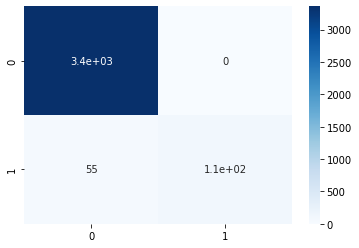

In [84]:
#@title
Model_Name.append('Random_Forest')
Model_Score1.append(round(accuracy_score(y_test, rf_pred), 4))
Model_Score2.append(round(precision_score(y_test, rf_pred), 4))
Model_Score3.append(round(recall_score(y_test, rf_pred), 4))
Model_Score4.append(round(f1_score(y_test, rf_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, rf_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, rf_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

**GradientBoosting**

In [85]:
#@title
gbc=GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_pred=gbc.predict(X_test)

In [86]:
#@title
print (roc_auc_score(y_test, gbc_pred))
print (classification_report(y_test, gbc_pred))

0.8146659609892717
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3359
           1       0.99      0.63      0.77       162

    accuracy                           0.98      3521
   macro avg       0.99      0.81      0.88      3521
weighted avg       0.98      0.98      0.98      3521



<Axes: >

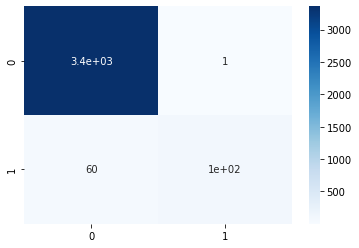

In [87]:
#@title
Model_Name.append('GradientBoostingClassifier')
Model_Score1.append(round(accuracy_score(y_test, gbc_pred), 4))
Model_Score2.append(round(precision_score(y_test, gbc_pred), 4))
Model_Score3.append(round(recall_score(y_test, gbc_pred), 4))
Model_Score4.append(round(f1_score(y_test, gbc_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, gbc_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, gbc_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

**XGBoost**

In [88]:
#@title
xgbc=XGBClassifier()
xgbc.fit(X_train, y_train)
xgbc_pred=xgbc.predict(X_test)

In [89]:
#@title
print (roc_auc_score(y_test, xgbc_pred))
print (classification_report(y_test, xgbc_pred))

0.8756500869232833
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3359
           1       0.95      0.75      0.84       162

    accuracy                           0.99      3521
   macro avg       0.97      0.88      0.92      3521
weighted avg       0.99      0.99      0.99      3521



<Axes: >

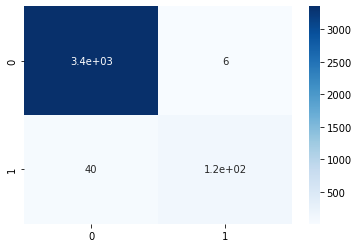

In [90]:
#@title
Model_Name.append('XGBoost')
Model_Score1.append(round(accuracy_score(y_test, xgbc_pred), 4))
Model_Score2.append(round(precision_score(y_test, xgbc_pred), 4))
Model_Score3.append(round(recall_score(y_test, xgbc_pred), 4))
Model_Score4.append(round(f1_score(y_test, xgbc_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, xgbc_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, xgbc_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

**MLP Classifier (solver = 'adam')**

In [94]:
#@title
mlp = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50, 30), max_iter=1000)

In [95]:
#@title
mlp_pred = mlp.predict(X_test)
print (roc_auc_score(y_test, mlp_pred))
print (classification_report(y_test, mlp_pred))

0.8785876528508264
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3359
           1       0.95      0.76      0.84       162

    accuracy                           0.99      3521
   macro avg       0.97      0.88      0.92      3521
weighted avg       0.99      0.99      0.99      3521



<Axes: >

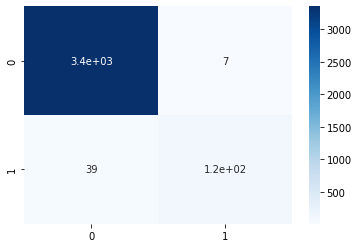

In [96]:
#@title
Model_Name.append('MLP-NN (adam)')
Model_Score1.append(round(accuracy_score(y_test, mlp_pred), 4))
Model_Score2.append(round(precision_score(y_test, mlp_pred), 4))
Model_Score3.append(round(recall_score(y_test, mlp_pred), 4))
Model_Score4.append(round(f1_score(y_test, mlp_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, mlp_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, mlp_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

**Plot Graph**

In [97]:
#@title
import matplotlib.pyplot as plt
%matplotlib inline

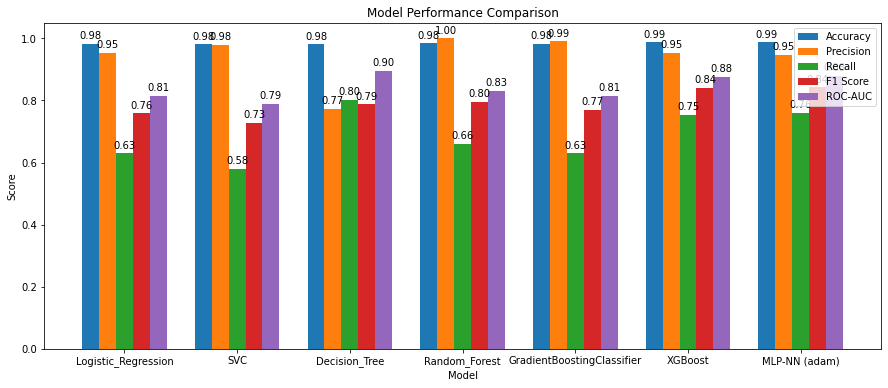

In [98]:
# Set the position of the bars on the x-axis
x = np.arange(len(Model_Name))

# Set the width of the bars
width = 0.15

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 6))

# Create the bars for each metric
rects1 = ax.bar(x - 2*width, Model_Score1, width, label='Accuracy')
rects2 = ax.bar(x - width, Model_Score2, width, label='Precision')
rects3 = ax.bar(x, Model_Score3, width, label='Recall')
rects4 = ax.bar(x + width, Model_Score4, width, label='F1 Score')
rects5 = ax.bar(x + 2*width, Model_Score5, width, label='ROC-AUC')

# Add labels, title and legend to the chart
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(Model_Name)
ax.legend()

# Add value labels to each bar
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
add_value_labels(rects1)
add_value_labels(rects2)
add_value_labels(rects3)
add_value_labels(rects4)
add_value_labels(rects5)
plt.savefig('Bar_Graph1.jpeg')
plt.show()

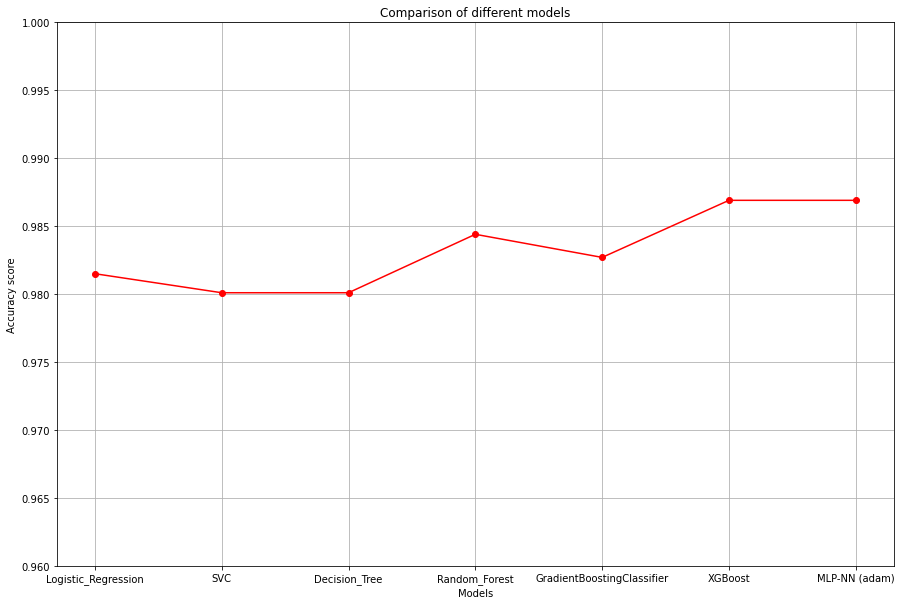

In [99]:
#@title
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score1, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('Accuracy score')
plt.ylim(0.96, 1.0)
plt.grid()
plt.savefig('Model_compare1.jpeg')
plt.show()

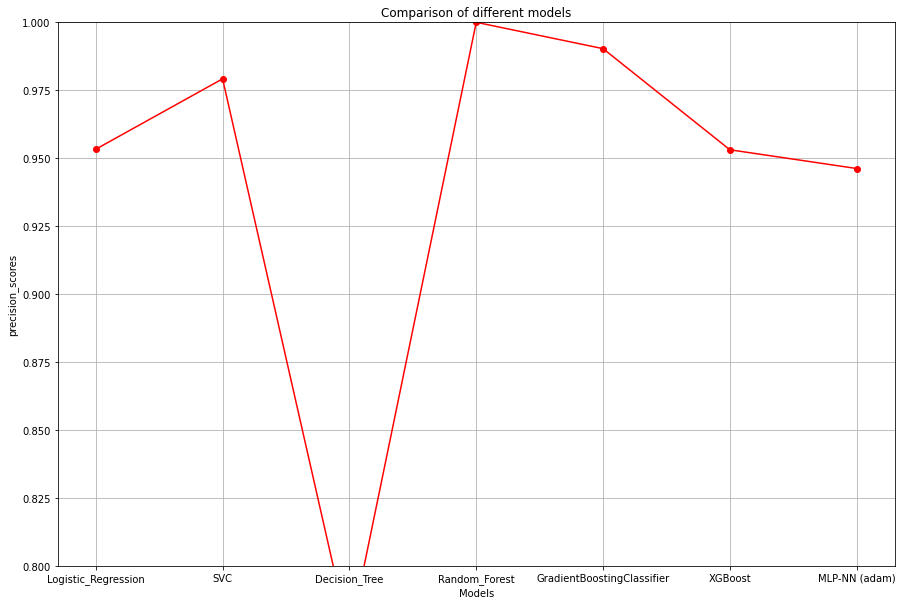

In [100]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score2, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('precision_scores')
plt.ylim(0.8, 1.0)
plt.grid()
plt.savefig('Model_compare2.jpeg')
plt.show()

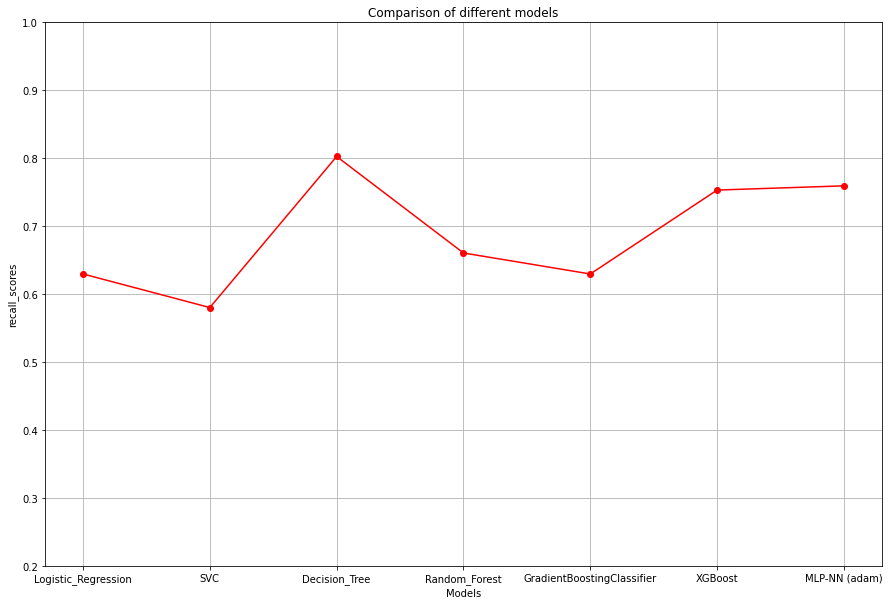

In [101]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score3, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('recall_scores')
plt.ylim(0.2, 1.0)
plt.grid()
plt.savefig('Model_compare3.jpeg')
plt.show()

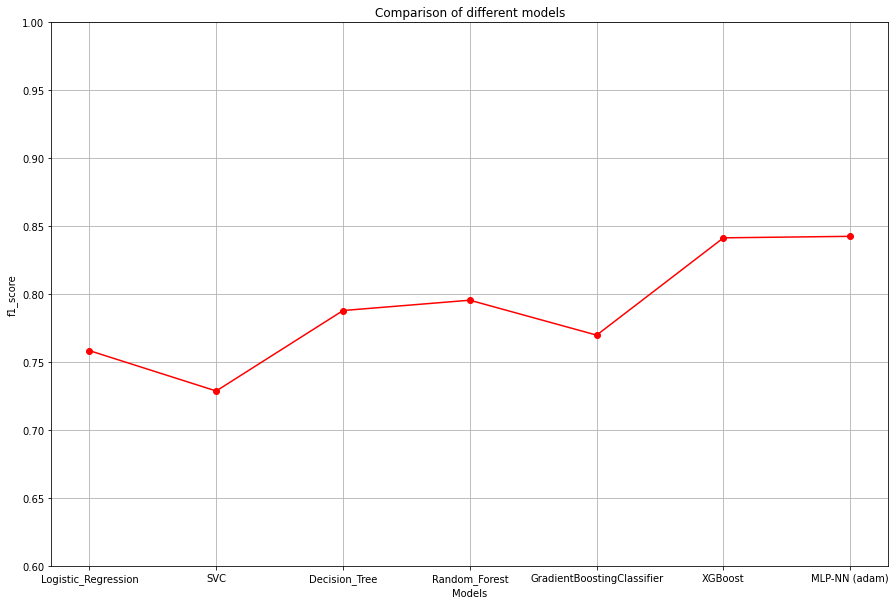

In [102]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score4, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('f1_score')
plt.ylim(0.6, 1.0)
plt.grid()
plt.savefig('Model_compare4.jpeg')
plt.show()

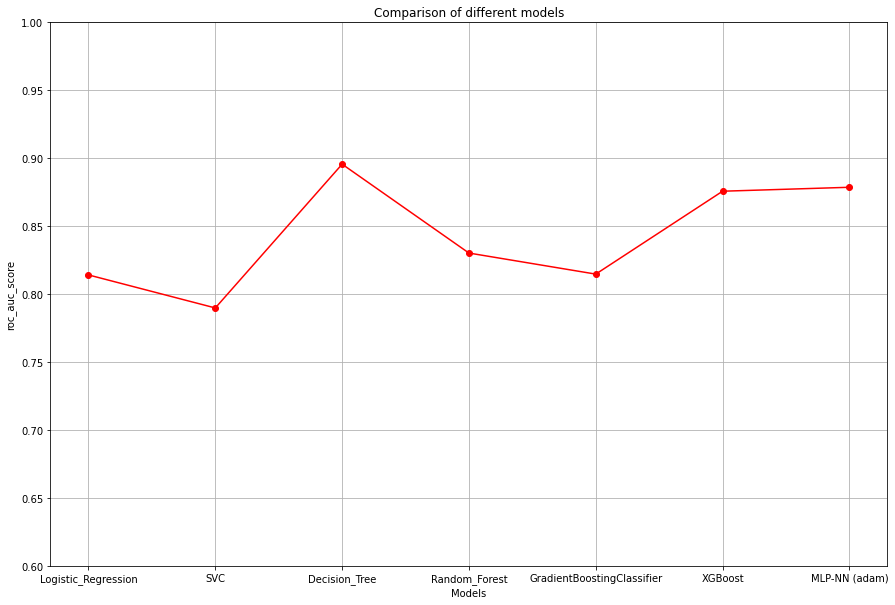

In [103]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score5, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('roc_auc_score')
plt.ylim(0.6, 1.0)
plt.grid()
plt.savefig('Model_compare5.jpeg')
plt.show()

In [104]:
#@title
voting_clf = VotingClassifier(estimators=[('rf', rf), ('mlp', mlp), ('xgbc', xgbc)], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(100, 50, 30),
                                            max_iter=1000)),
                             ('xgbc',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft')

In [105]:
#@title
voting_clf_pred = voting_clf.predict(X_test)
print (roc_auc_score(y_test, voting_clf_pred))
print (classification_report(y_test, voting_clf_pred))
print (accuracy_score(y_test, voting_clf_pred))

0.8762455022254566
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3359
           1       0.98      0.75      0.85       162

    accuracy                           0.99      3521
   macro avg       0.99      0.88      0.92      3521
weighted avg       0.99      0.99      0.99      3521

0.9880715705765407


<Axes: >

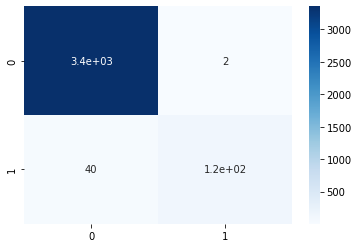

In [106]:
#@title
Model_Name.append('Voting Classifier')
Model_Score1.append(round(accuracy_score(y_test, voting_clf_pred), 4))
Model_Score2.append(round(precision_score(y_test, voting_clf_pred), 4))
Model_Score3.append(round(recall_score(y_test, voting_clf_pred), 4))
Model_Score4.append(round(f1_score(y_test, voting_clf_pred), 4))
Model_Score5.append(round(roc_auc_score(y_test, voting_clf_pred), 4))

# Generate confusion matrix
cm = confusion_matrix(y_test, voting_clf_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')


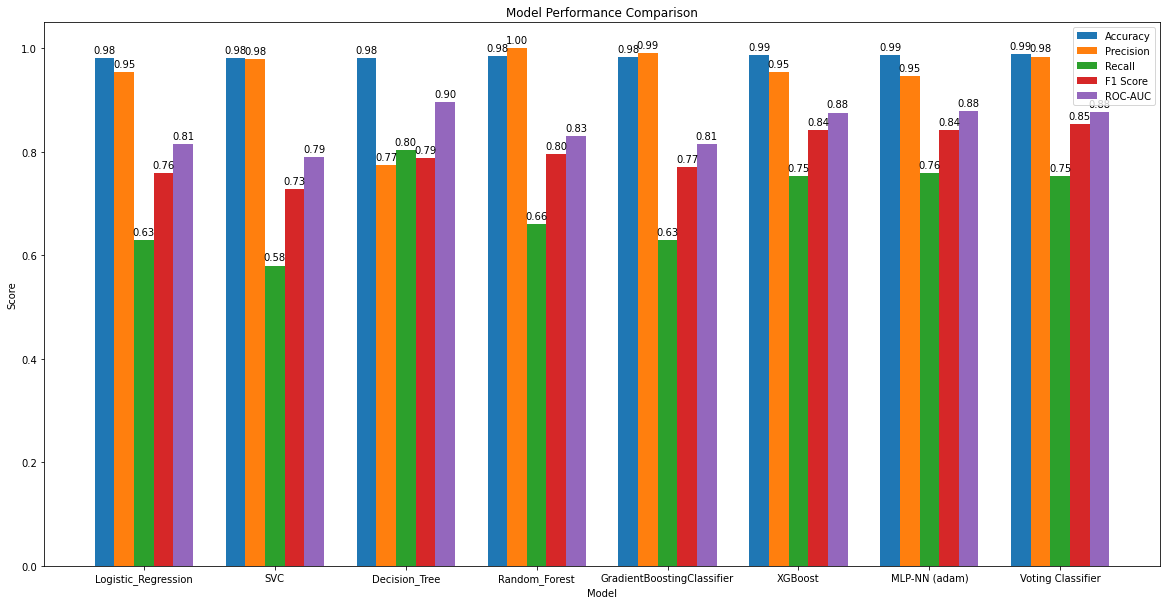

In [107]:
# Set the position of the bars on the x-axis
x = np.arange(len(Model_Name))

# Set the width of the bars
width = 0.15

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))

# Create the bars for each metric
rects1 = ax.bar(x - 2*width, Model_Score1, width, label='Accuracy')
rects2 = ax.bar(x - width, Model_Score2, width, label='Precision')
rects3 = ax.bar(x, Model_Score3, width, label='Recall')
rects4 = ax.bar(x + width, Model_Score4, width, label='F1 Score')
rects5 = ax.bar(x + 2*width, Model_Score5, width, label='ROC-AUC')

# Add labels, title and legend to the chart
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(Model_Name)
ax.legend()

# Add value labels to each bar
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
add_value_labels(rects1)
add_value_labels(rects2)
add_value_labels(rects3)
add_value_labels(rects4)
add_value_labels(rects5)
plt.savefig('Bar_Graph2.jpeg')
plt.show()

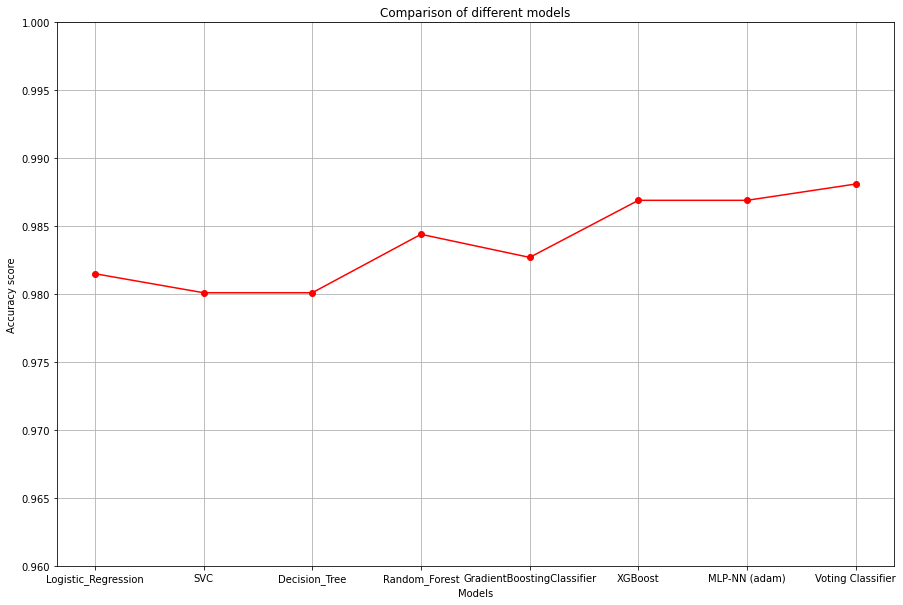

In [108]:
#@title
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score1, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('Accuracy score')
plt.ylim(0.96, 1.0)
plt.grid()
plt.savefig('Model_compare_final1.jpeg')
plt.show()

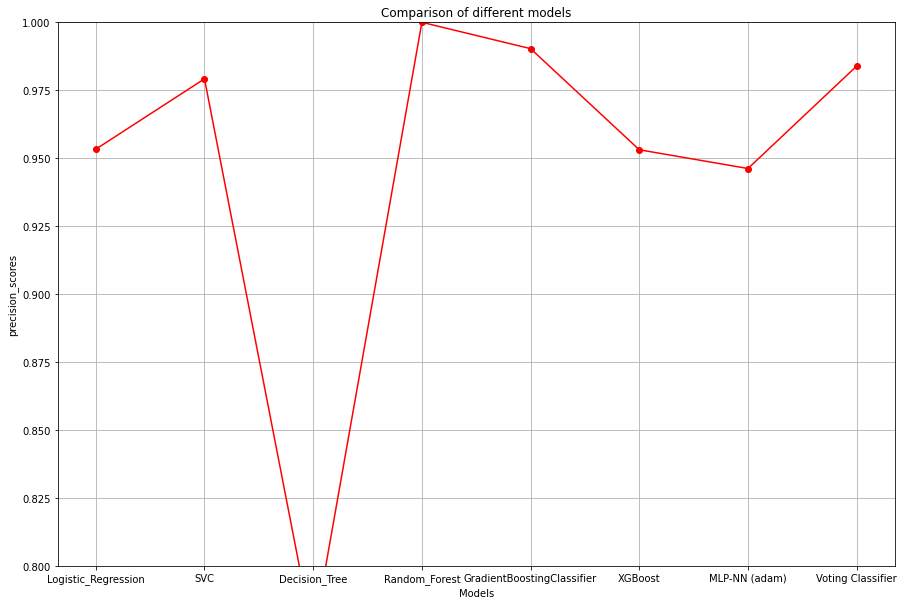

In [109]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score2, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('precision_scores')
plt.ylim(0.8, 1.0)
plt.grid()
plt.savefig('Model_compare_final2.jpeg')
plt.show()

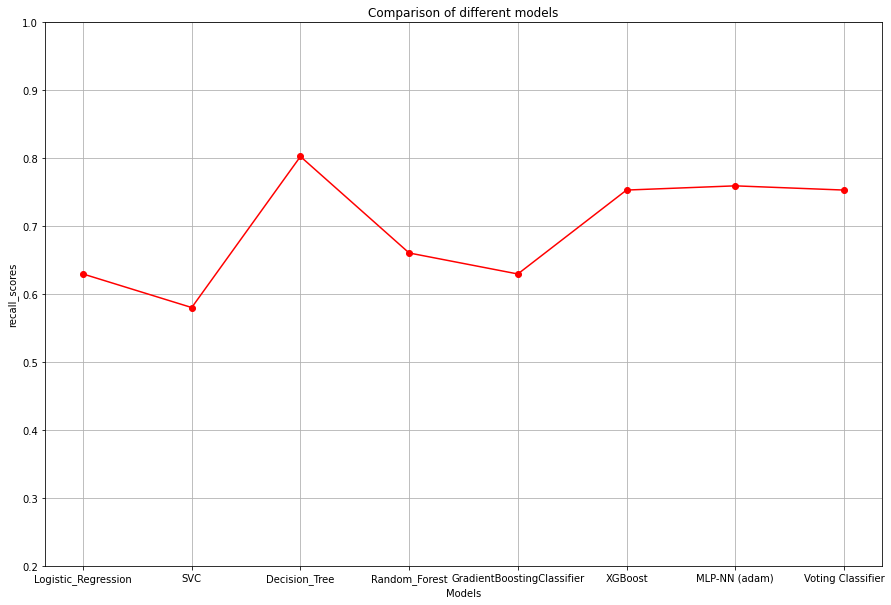

In [110]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score3, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('recall_scores')
plt.ylim(0.2, 1.0)
plt.grid()
plt.savefig('Model_compare_final3.jpeg')
plt.show()

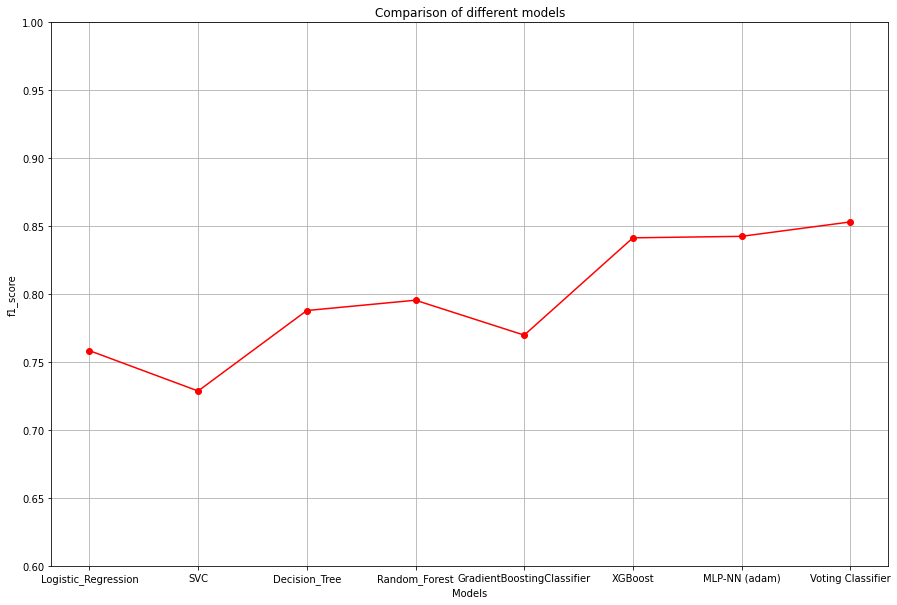

In [111]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score4, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('f1_score')
plt.ylim(0.6, 1.0)
plt.grid()
plt.savefig('Model_compare_final4.jpeg')
plt.show()

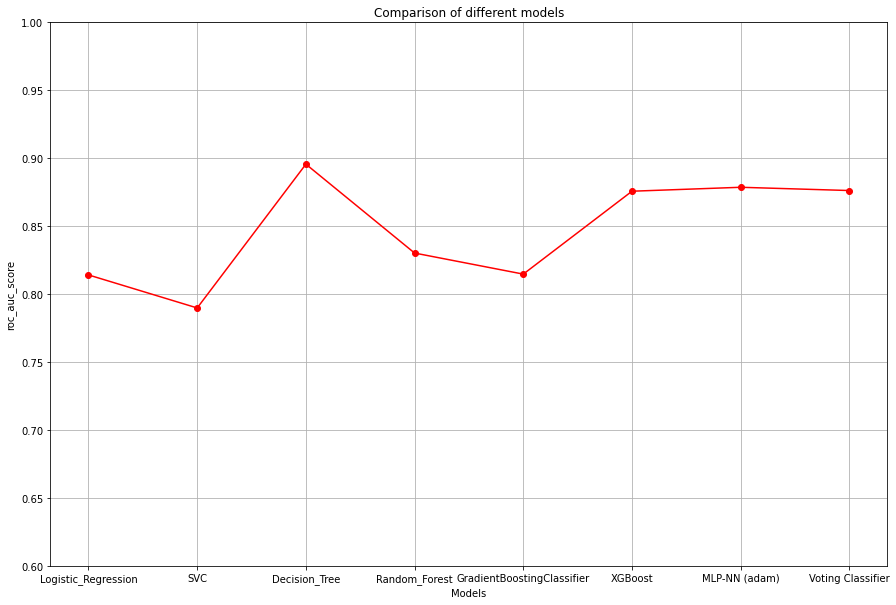

In [112]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score5, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('roc_auc_score')
plt.ylim(0.6, 1.0)
plt.grid()
plt.savefig('Model_compare_final5.jpeg')
plt.show()

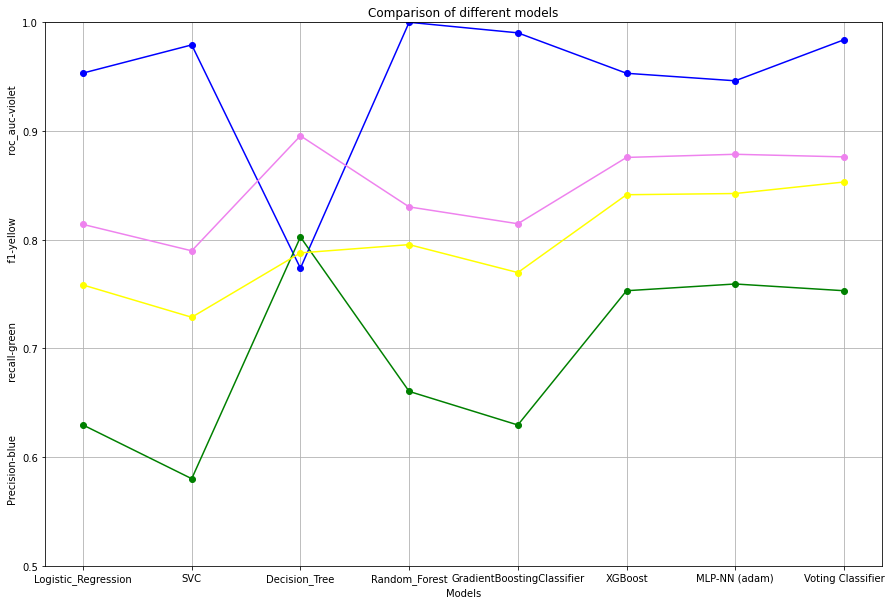

In [113]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score2, marker = 'o', color = 'blue')
plt.plot(Model_Name,Model_Score3, marker = 'o', color = 'green')
plt.plot(Model_Name,Model_Score4, marker = 'o', color = 'yellow')
plt.plot(Model_Name,Model_Score5, marker = 'o', color = 'Violet')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('Precision-blue                 recall-green                   f1-yellow                    roc_auc-violet')
plt.ylim(0.5, 1.0)
plt.grid()
plt.savefig('Model_compare_final_all.jpeg')
plt.show()

In [114]:
#@title
with open('voting_model1.sav', 'wb') as file:
    pickle.dump(voting_clf, file)

In [115]:
#@title
with open('final_preprocessor1.sav', 'wb') as file:
    pickle.dump(preprocessor, file)